In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Paper 1: A Data Mining Approach to Flight Arrival Delay Prediction for American Airline


---



#Data Setup
Concatenate all months of 2015 and 2016 flght data into a single CSV file, and select columns that match the ones used in the paper https://arxiv.org/abs/1903.06740


In [ ]:
import csv
import os
import pandas as pd

#list all the files from 2015 and 2016 directories
file_list_2015 = os.listdir('/content/drive/My Drive/ENSF544-Project1/2015/')
file_list_2016 = os.listdir('/content/drive/My Drive/ENSF544-Project1/2016/')

#concatenate all 2015 and 2016 files together, and then sort 2016 by month
df2015 = pd.concat([pd.read_csv('/content/drive/My Drive/ENSF544-Project1/2015/' + f) for f in file_list_2015 ], ignore_index=True)
df2016 = pd.concat([pd.read_csv('/content/drive/My Drive/ENSF544-Project1/2016/' + f) for f in file_list_2016 ], ignore_index=True)
df2016 = df2016.sort_values('MONTH')

#concatenate 2015 and 2016 data into another dataframe
df = pd.concat([df2015, df2016])
print(df2015.shape, df2016.shape, df.shape)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()


(5819079, 37) (5617658, 37) (11436737, 37)


In [ ]:
df = pd.concat([df2015, df2016])
#remove columns that are not used in the paper by selecting the following columns:
  #month, day of month, day of week, flight num, origin airport id, origin world area code, dest airport id, dest word area code, crs dep time, crs arr time, arr del 15

#airline id is also kept to select only american airlines flights later

df = df[['MONTH','DAY_OF_MONTH','DAY_OF_WEEK','OP_CARRIER_AIRLINE_ID','OP_CARRIER_FL_NUM','ORIGIN','ORIGIN_WAC','DEST','DEST_WAC','CRS_DEP_TIME','CRS_ARR_TIME','ARR_DEL15']]
del(df2015)
del(df2016)

#Data Preprocessing
Consists of the following steps:

1.   Filter data for only **American Airline flights** from **top 5 busiest airports**
1.   Remove instances with a **missing value** for the label **ARR_DEL15**
2.   **Label encode** categorical features alphabetically starting with 0
3.   **One-Hot Encode** select features
4.   **Data balance** the ARR_DEL15 label 





In [ ]:
#Only keep instances of American Airlines flights, i.e OP_CARRIER_AIRLINE_ID = 19805, then remove the OP_CARRIER_AIRLINE_ID column 
#Also only keep instances where ORIGIN and DEST = one of ['LAX', 'ATL', 'ORD', 'JFK', 'DFW']

df = df[df['OP_CARRIER_AIRLINE_ID'] == 19805]
df = df.drop('OP_CARRIER_AIRLINE_ID', axis=1)

airports = ['LAX', 'ATL', 'ORD', 'JFK', 'DFW']
df = df[df['ORIGIN'].isin(airports)]
df = df[df['DEST'].isin(airports)]
print(df.shape)

(98158, 11)


In [ ]:
#2. Removing instances that do not have the value 0 or 1 for ARR_DEL15
df = df.dropna()
df.shape

(96544, 11)

In [ ]:
#3. label encode categorical features (all columns but crs dep time, arr time, arr del 15)
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

catCols = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'OP_CARRIER_FL_NUM', 'ORIGIN', 'ORIGIN_WAC', 'DEST', 'DEST_WAC']

# Encode Categorical Features
label_encoder = preprocessing.LabelEncoder()
df[catCols] = df[catCols].apply(label_encoder.fit_transform)
print(df.shape)

(96544, 11)


In [ ]:
#4. One hot encode the following features: ORIGIN, ORIGIN_WAC, DEST, DEST_WAC
oh_cols = ['ORIGIN', 'ORIGIN_WAC', 'DEST', 'DEST_WAC']
df = pd.get_dummies(df, columns=['ORIGIN', 'ORIGIN_WAC', 'DEST', 'DEST_WAC'])
df.shape

(96544, 27)

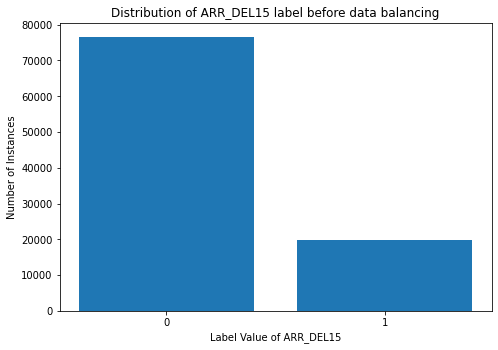

In [ ]:
#Before data balancing plot
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['0', '1']

#Count of ARR_DEL15 = 0 : 76673
#Count of ARR_DEL15 = 1 : 19871
instances = [df[df['ARR_DEL15']==0].shape[0],df[df['ARR_DEL15']==1].shape[0]] 

ax.bar(labels,instances)
ax.set_ylabel('Number of Instances')
ax.set_xlabel('Label Value of ARR_DEL15')
ax.set_title('Distribution of ARR_DEL15 label before data balancing')
plt.show()

In [ ]:
#5 data balancing using 200% Randomized-SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTENC 

#divide dataset into labels and features
label=df['ARR_DEL15']
features = df.loc[:, df.columns != 'ARR_DEL15']
print(features.shape, label.shape)

#following the paper, sampling_strategy ratio is set to 0.7755 for 200% R-Smote, k_neighbours = 2, and categorical features are identified as all indexes in features except 4 (CRS_DEP_TIME) and 5 (CRS_ARR_TIME)
smote = SMOTENC([0,1,2,3,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],random_state = 1, sampling_strategy=0.7755, k_neighbors = 2) 

X, y = smote.fit_resample(features, label) #takes 60s to execute

(96544, 26) (96544,)


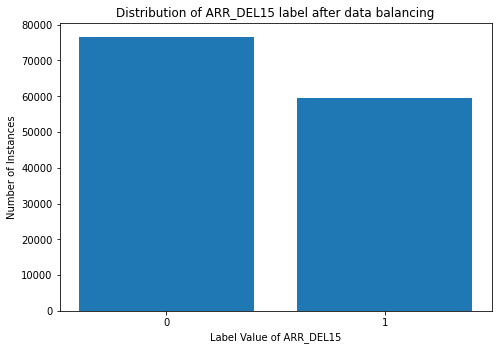

In [ ]:
#After data balancing plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['0', '1']

#Count of ARR_DEL15 = 0 : 76673
#Count of ARR_DEL15 = 1 : 59459
instances = [y.value_counts()[0],y.value_counts()[1]] 

ax.bar(labels,instances)
ax.set_ylabel('Number of Instances')
ax.set_xlabel('Label Value of ARR_DEL15')
ax.set_title('Distribution of ARR_DEL15 label after data balancing')
plt.show()

features = X.copy() #new feature instances
label = y.copy() #new labels 

In [ ]:
print(features.columns, y.head)
del(X)
del(y)

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_FL_NUM',
       'CRS_DEP_TIME', 'CRS_ARR_TIME', 'ORIGIN_0', 'ORIGIN_1', 'ORIGIN_2',
       'ORIGIN_3', 'ORIGIN_4', 'ORIGIN_WAC_0', 'ORIGIN_WAC_1', 'ORIGIN_WAC_2',
       'ORIGIN_WAC_3', 'ORIGIN_WAC_4', 'DEST_0', 'DEST_1', 'DEST_2', 'DEST_3',
       'DEST_4', 'DEST_WAC_0', 'DEST_WAC_1', 'DEST_WAC_2', 'DEST_WAC_3',
       'DEST_WAC_4'],
      dtype='object') <bound method NDFrame.head of 0         1.0
1         0.0
2         1.0
3         0.0
4         0.0
         ... 
136127    1.0
136128    1.0
136129    1.0
136130    1.0
136131    1.0
Name: ARR_DEL15, Length: 136132, dtype: float64>


# Gradient Boosting Classifier with Grid Search

In [ ]:
#First, split training and test data 80:20
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    features, label, test_size = 0.20, random_state=2)

#According to the paper, grid search found the optimal hyperparameters to be 400 estimators with a max depth of 5, these hyperparameters are used in the model below
clf = GradientBoostingClassifier(n_estimators=400,max_depth=5, random_state=7).fit(X_train, y_train) #takes 125 seconds
trainingScore = clf.score(X_train, y_train)
testScore = clf.score(X_test, y_test)

print(trainingScore, testScore)

0.7448693815710941 0.7228853711389429


In [ ]:
#obtaining recall, precision, and F1 scores
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

y_pred = clf.predict(X_test)

recall = recall_score(y_test, y_pred)
print("Recall {:0.2f}\n".format(recall))

recall = recall_score(y_test, y_pred)
print("Recall {:0.2f}\n".format(recall))

precision = precision_score(y_test, y_pred)
print("Precision {:0.2f}\n".format(precision))

f1 = f1_score(y_test, y_pred)
print("F1 Score {:0.2f}\n".format(f1))

auroc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("AUROC {:0.2f}\n".format(auroc))

Recall 0.58

Precision 0.73

F1 Score 0.64

AUROC 0.79



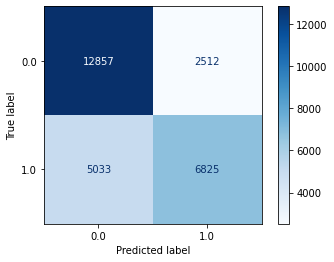

In [ ]:
#Confusion matrix plot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)


disp.plot(cmap=plt.cm.Blues)


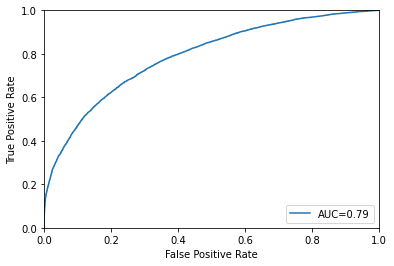

In [ ]:
#ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

plt.plot(fpr,tpr,label="AUC="+"{:0.2f}".format(auroc))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim((0,1.0))
plt.ylim((0,1.0))
plt.legend(loc=4)
plt.show()

# Modification - Random Search
Random Search is used to find the optimal hyperparameters instead of Grid Search

Different parameters are also tested, to see if expanding the parameter range would have led to more accurate results.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import csv

X_train, X_test, y_train, y_test = train_test_split(
    features, label, test_size = 0.20, random_state=2)

clf2 = GradientBoostingClassifier(random_state=8)

# define parameter range for n_estimator and max_depth (like paper)
param_grid = {'n_estimators':range(350,651,50),  #[350,400,450,500,550,600,650], compared to range(100,501,50) tested the paper
              'max_depth': [4, 5, 6, 7]}  #compared to [3,4,5] in paper

grid = RandomizedSearchCV(clf2, param_grid, refit = True, verbose = 10,n_jobs=1)
print(grid.fit(X_train, y_train)) #takes 2 hours to run
print(grid.best_params_)
g = grid.cv_results_

#saving results of random search CV
with open('/content/drive/My Drive/ENSF544-Project1/randomSearchCVResults.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f,delimiter=",")
    for k,v in g.items():
      writer.writerow([k,v])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=5, n_estimators=550..............................
[CV 1/5; 1/10] END max_depth=5, n_estimators=550;, score=0.736 total time= 2.2min
[CV 2/5; 1/10] START max_depth=5, n_estimators=550..............................
[CV 2/5; 1/10] END max_depth=5, n_estimators=550;, score=0.729 total time= 2.2min
[CV 3/5; 1/10] START max_depth=5, n_estimators=550..............................
[CV 3/5; 1/10] END max_depth=5, n_estimators=550;, score=0.733 total time= 2.1min
[CV 4/5; 1/10] START max_depth=5, n_estimators=550..............................
[CV 4/5; 1/10] END max_depth=5, n_estimators=550;, score=0.730 total time= 2.2min
[CV 5/5; 1/10] START max_depth=5, n_estimators=550..............................
[CV 5/5; 1/10] END max_depth=5, n_estimators=550;, score=0.733 total time= 2.1min
[CV 1/5; 2/10] START max_depth=7, n_estimators=650..............................
[CV 1/5; 2/10] END max_depth=7, n_estimator

In [ ]:
#Evaluate model perform on new parameters
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

y_pred = grid.predict(X_test) #uses the best found params

recall = recall_score(y_test, y_pred)
print("Recall {:0.2f}\n".format(recall))

precision = precision_score(y_test, y_pred)
print("Precision {:0.2f}\n".format(precision))

f1 = f1_score(y_test, y_pred)
print("F1 Score {:0.2f}\n".format(f1))

grid_prob =grid.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, grid_prob)
print("AUROC {:0.2f}\n".format(auroc))

trainingScore = grid.score(X_train, y_train)
testScore = grid.score(X_test, y_test)

print(trainingScore, testScore)

Recall 0.69

Precision 0.79

F1 Score 0.74

AUROC 0.86

0.8605573665120977 0.7889594887427921


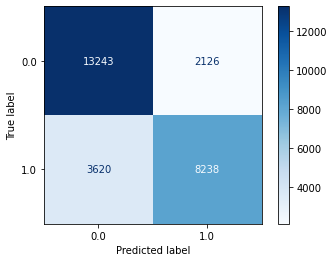

In [ ]:
#Confusion matrix plot for modification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)


disp.plot(cmap=plt.cm.Blues)

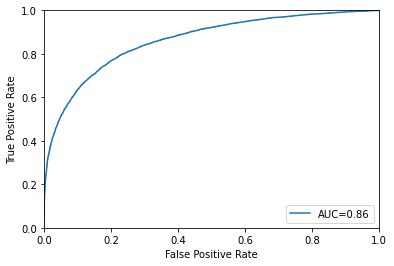

In [ ]:
#ROC Curve for modification
fpr, tpr, thresholds = roc_curve(y_test, grid_prob)

plt.plot(fpr,tpr,label="AUC="+"{:0.2f}".format(auroc))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim((0,1.0))
plt.ylim((0,1.0))
plt.legend(loc=4)
plt.show()